In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [3]:
import sys
sys.path.append("../")
from config import DATASETS_PATH, ASSETS_PATH, COLOURS

In [4]:
MY_ASSETS_PATH = os.path.join(ASSETS_PATH, 'data_exploration_and_analysis')
LABELS_PATH = os.path.join(DATASETS_PATH, 'labels.csv')
labels_df = pd.read_csv(LABELS_PATH)

In [5]:
labels_df.head() # view format

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


### Identify and fix errors

In [6]:
# first replace all empty string with NaN
labels_df = labels_df.replace(r'^\s*$', np.nan, regex=True)

In [7]:
# test number of non-empty image names matches number of training images
TRAIN_IMGS_PATH = os.path.join(DATASETS_PATH, 'train')
n_images = len(os.listdir(TRAIN_IMGS_PATH))
n_image_names = pd.notnull(labels_df["image_name"]).sum()
assert n_images == n_image_names

In [8]:
# test whether an image is labelled twice
n_duplicated = labels_df["image_name"].duplicated().sum()
assert n_duplicated == 0

In [9]:
# check if any image does not have assigned labels
n_empty = pd.isnull(labels_df["tags"]).sum()
assert n_empty == 0

### Labels

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

In [11]:
# labels in the dataset
vectorizer.fit(labels_df['tags'].to_list())
labels = vectorizer.get_feature_names()
print(labels)

['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation', 'haze', 'partly_cloudy', 'primary', 'road', 'selective_logging', 'slash_burn', 'water']


### Reformat dataset
replace single column of tags to multiple columns with indicator variables for each tag (label)

In [12]:
# first remove any possible duplicates
def remove_string_duplicates(s):
    return ' '.join((set(s.split())))

labels_df['tags'] = labels_df['tags'].apply(remove_string_duplicates)

In [13]:
indicator_values = vectorizer.transform(labels_df['tags'])
indicator_df = pd.DataFrame(data=indicator_values.todense(), columns=labels)
indicator_df = pd.concat([labels_df, indicator_df], axis="columns")

In [14]:
indicator_df.head()

,image_name,tags,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,train_0,primary haze,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,train_1,agriculture clear primary water,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,train_2,primary clear,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,train_3,primary clear,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,train_4,agriculture habitation clear road primary,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0


### Label distribution

In [15]:
label_count = indicator_df[labels].sum(axis = 0)
label_count.sort_values(ascending=False, inplace=True)
sorted_labels = label_count.index.tolist()

Text(0, 0.5, 'Frequency')

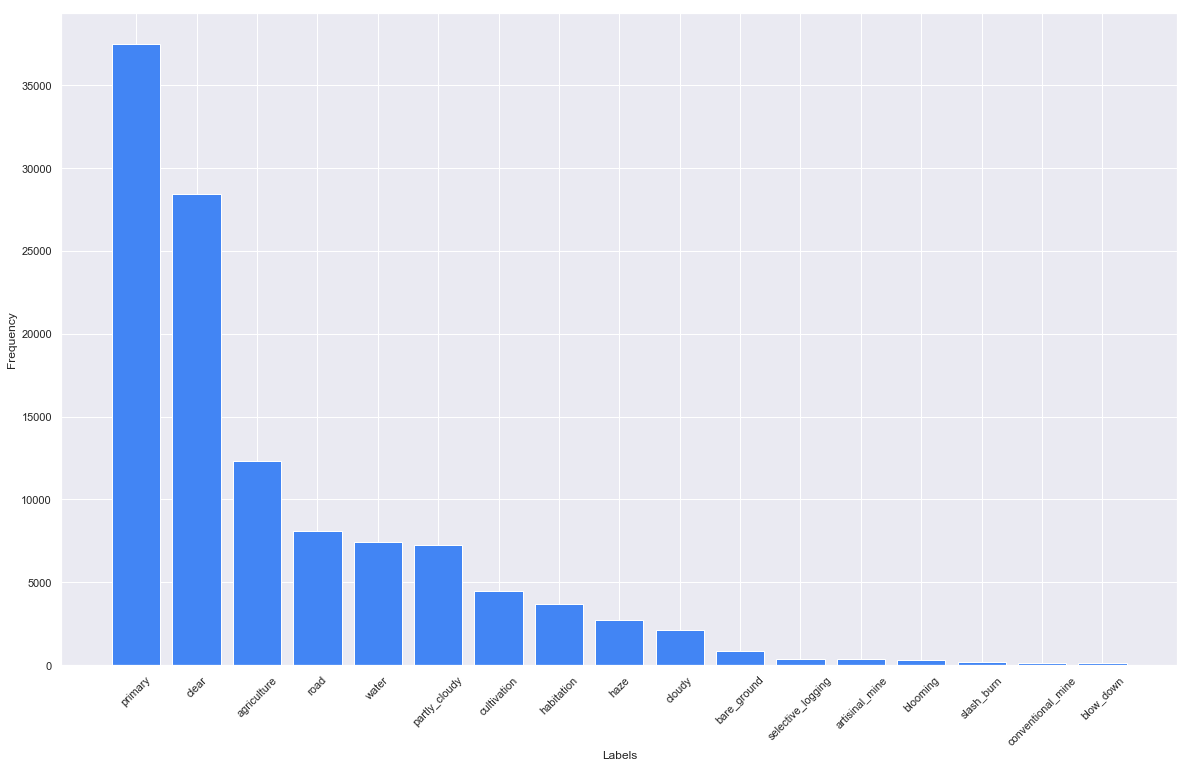

In [9]:
fig_label_distribution = plt.figure(figsize=(20, 12))
plt.bar(sorted_labels, label_count, color=COLOURS['blue'])
plt.xticks(rotation=45)
plt.xlabel('Labels')
plt.ylabel('Frequency')

In [10]:
label_distribution_path = os.path.join(MY_ASSETS_PATH, 'label_distribution.png')
fig_label_distribution.savefig(label_distribution_path, dpi=300)

identify percentage of common and rare labels

In [58]:
common_labels = ['agriculture', 'road', 'water', 'cultivation', 'habitation', 'bare_ground']
rare_labels = ['selective_logging', 'artisinal_mine', 'blooming', 'slash_burn', 'blow_down', 'conventional_mine']

def count_proportion_with_label(indicator_df, labels):
    total = len(indicator_df.index)
    with_label = (indicator_df[labels].sum(axis=1) > 0).sum()
    return round(with_label / total * 100, 2)

In [59]:
percent_common_labels = count_proportion_with_label(indicator_vals_df, common_labels)
print(f'{percent_common_labels} percent of the dataset has one of the following labels: {", ".join(common_labels)}')
      
percent_rare_labels = count_proportion_with_label(indicator_vals_df, rare_labels)
print(f'{percent_rare_labels} percent of the dataset has one of the following labels: {", ".join(rare_labels)}')

47.3 percent of the dataset has one of the following labels: agriculture, road, water, cultivation, habitation, bare_ground
3.44 percent of the dataset has one of the following labels: selective_logging, artisinal_mine, blooming, slash_burn, blow_down, conventional_mine


output sorted indicator labels df to csv for future use

In [27]:
#sort df
sorted_columns = ['image_name', 'tags'] + sorted_labels
df_indicator_sorted = indicator_df[sorted_columns]

,image_name,tags,primary,clear,agriculture,road,water,partly_cloudy,cultivation,habitation,haze,cloudy,bare_ground,selective_logging,artisinal_mine,blooming,slash_burn,conventional_mine,blow_down
0,train_0,primary haze,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,train_1,agriculture clear primary water,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,train_2,primary clear,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,train_3,primary clear,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,train_4,agriculture habitation clear road primary,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0


In [28]:
#export
indicator_labels_path = os.path.join(DATASETS_PATH, 'indicator_labels.csv')
df_indicator_sorted.to_csv(indicator_labels_path, index=False)

### Label realtions

In [23]:
indicator_vals_df = indicator_df[sorted_labels]
label_coocurrance = indicator_vals_df.T.dot(indicator_vals_df)

In [24]:
label_coocurrance

,primary,clear,agriculture,road,water,partly_cloudy,cultivation,habitation,haze,cloudy,bare_ground,selective_logging,artisinal_mine,blooming,slash_burn,conventional_mine,blow_down
primary,37513,27668,11972,7728,7001,7175,4455,3469,2670,0,683,340,324,332,209,94,98
clear,27668,28431,9150,6295,5502,0,3527,3090,0,0,747,308,307,311,173,70,85
agriculture,11972,9150,12315,6034,2712,2493,3377,2737,672,0,225,65,38,32,119,24,22
road,7728,6295,6034,8071,2125,1382,1294,2786,394,0,323,151,110,10,36,59,2
water,7001,5502,2712,2125,7411,1295,868,915,613,0,206,49,299,16,24,26,3
partly_cloudy,7175,0,2493,1382,1295,7261,748,441,0,0,74,27,27,17,33,28,13
cultivation,4455,3527,3377,1294,868,748,4477,895,202,0,89,58,18,35,126,4,8
habitation,3469,3090,2737,2786,915,441,895,3660,129,0,163,13,29,4,41,36,3
haze,2670,0,672,394,613,0,202,129,2697,0,41,5,5,4,3,2,0
cloudy,0,0,0,0,0,0,0,0,0,2089,0,0,0,0,0,0,0


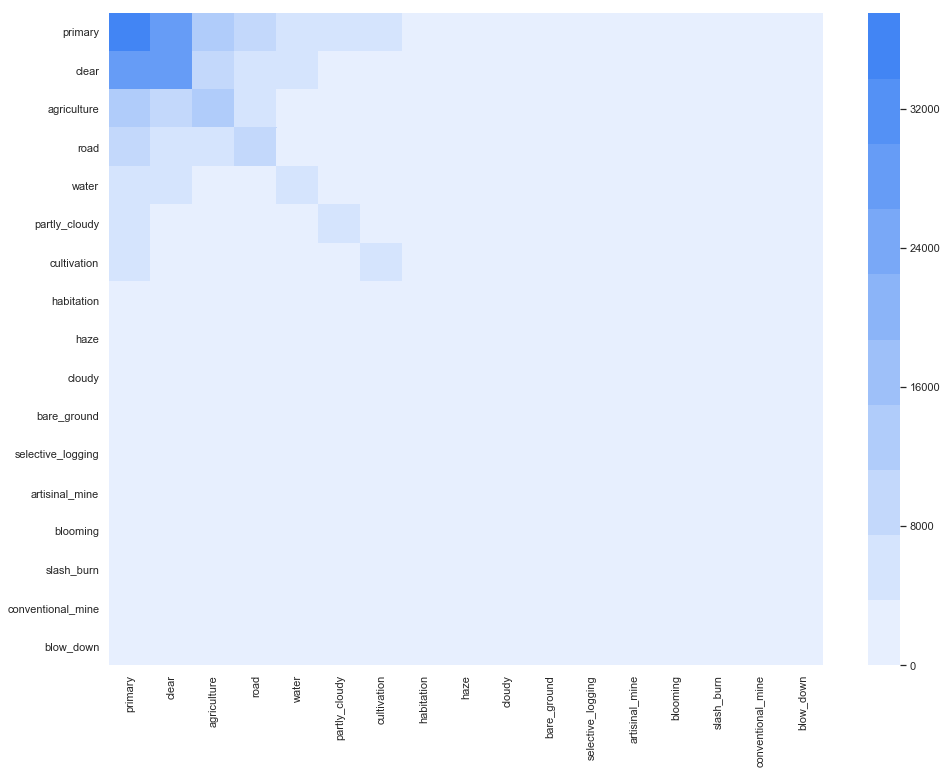

In [25]:
blue_palette = sns.light_palette(COLOURS['blue'], 10)
sns.set(rc={'figure.figsize':(16,12)})
fig_coocurrance = sns.heatmap(label_coocurrance, cmap=blue_palette)

In [16]:
label_coocurrance_path = os.path.join(MY_ASSETS_PATH, 'label_coocurrance.png')
fig_coocurrance.get_figure().savefig(label_coocurrance_path, dpi=300)

Because the primary and clear labels are so dominant over the rest the regular co-ocurrance matrix does not provide us much information on the relation between the labels. We can expose more information by crating a new matrix which shows **what percentage of the label on the Y axis also has the label on the X axis**

In [12]:
label_relations = (label_coocurrance.T / label_count).T

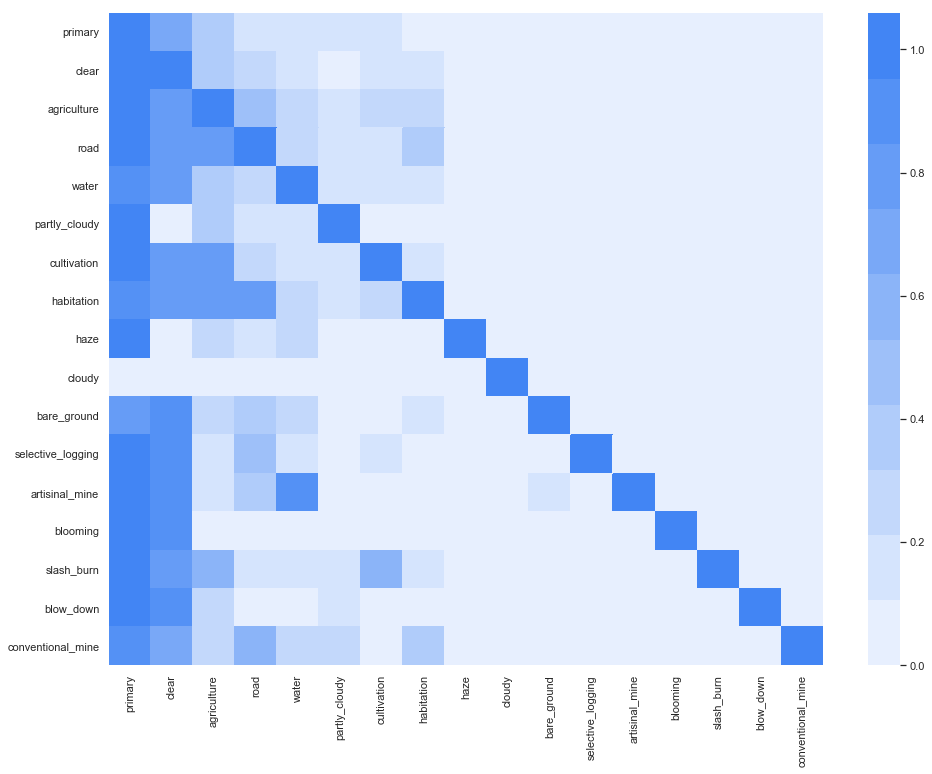

In [15]:
fig_relations = sns.heatmap(label_relations, cmap=blue_palette)

In [ ]:
label_relations_path = os.path.join(MY_ASSETS_PATH, 'label_relations.png')
fig_relations.get_figure().savefig(label_relations_path, dpi=300)